<a href="https://colab.research.google.com/github/Youka419/AIpassportmogi/blob/main/%E8%B2%A9%E5%A3%B2%E5%93%A1%E5%88%A5%E4%BD%9C%E6%88%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Google Drive がマウントされたら、ファイルパスを Google Drive 内の該当フォルダに変更します。

In [2]:
import pandas as pd
import os
from datetime import datetime
import pytz # タイムゾーンを扱うために必要

# 文字コードのフォールバック対応
def read_csv_safely(path: str) -> pd.DataFrame:
    for enc in ["utf-8", "cp932", "shift_jis"]:
        try:
            return pd.read_csv(path, encoding=enc)
        except UnicodeDecodeError:
            continue
    # 最後の手段: エンコーディング自動判定なしで失敗を投げる
    return pd.read_csv(path)

if __name__ == "__main__":
    print("=== 販売員別 積み上げグラフ用CSV 作成 ===")

    # 入力ファイル (Google Drive上のパスに変更)
    base_dir = "/content/drive/MyDrive/MDXQ" # フォルダパス。必要に応じて変更してください。
    tx_path = f"{base_dir}/約定データ一覧表.csv"
    products_path = f"{base_dir}/商品リスト.csv"
    suitability_path = f"{base_dir}/適合性判定シート一覧表.csv" # 適合性判定シート一覧表.csvのパスも追加

    # 日本時間のタイムスタンプで出力フォルダを作成
    jst = pytz.timezone('Asia/Tokyo')
    timestamp = datetime.now(jst).strftime('%Y%m%d_%H%M%S')
    output_dir = f"{base_dir}/{timestamp}"
    os.makedirs(output_dir, exist_ok=True)
    print(f"出力フォルダを作成しました: {output_dir}")


    # 読み込み
    df_tx = read_csv_safely(tx_path)
    df_products = read_csv_safely(products_path)

    # 必須カラムの存在チェック（販売員IDは後でフォールバック対応）
    required_tx_cols_base = {"顧客ID", "商品名", "取引コード", "取得価額", "取引日"}
    missing_tx_base = required_tx_cols_base - set(df_tx.columns)
    if missing_tx_base:
        raise KeyError(f"約定データ一覧表.csv に不足カラム: {sorted(missing_tx_base)}")

    required_prod_cols = {"商品名", "商品カテゴリ"}
    missing_prod = required_prod_cols - set(df_products.columns)
    if missing_prod:
        raise KeyError(f"商品リスト.csv に不足カラム: {sorted(missing_prod)}")

    # 販売員IDが無い場合は適合性判定シートから付与
    if "販売員ID" not in df_tx.columns:
        print("販売員IDが見つからないため、適合性判定シート一覧表.csvから付与します...")
        # suitability_path = "適合性判定シート一覧表.csv" # パスは上で定義済み
        df_suit = read_csv_safely(suitability_path)
        if not {"顧客ID", "販売員ID", "取引日"}.issubset(df_suit.columns):
            raise KeyError("適合性判定シート一覧表.csv から 販売員ID を付与できません（顧客ID/販売員ID/取引日 のいずれかが不足）。")
        # 取引日の最新で販売員IDを確定（顧客IDごと）
        df_suit["取引日"] = pd.to_datetime(df_suit["取引日"], errors="coerce")
        df_suit = df_suit.sort_values(["顧客ID", "取引日"], ascending=[True, False])
        latest_sales_by_customer = df_suit.dropna(subset=["顧客ID", "販売員ID"]).drop_duplicates("顧客ID")[
            ["顧客ID", "販売員ID"]
        ]
        df_tx = df_tx.merge(latest_sales_by_customer, on="顧客ID", how="left")
        if df_tx["販売員ID"].isna().any():
            # 未取得は一時IDとして "未割当" を付与（集計可能にする）
            df_tx["販売員ID"] = df_tx["販売員ID"].fillna("未割当")
    else:
        # 既存の販売員IDをそのまま使用
        pass


    # 商品カテゴリの付与
    product_category_map = (
        df_products[["商品名", "商品カテゴリ"]]
        .drop_duplicates()
        .set_index("商品名")["商品カテゴリ"]
    )
    df_tx["商品カテゴリ"] = df_tx["商品名"].map(product_category_map).fillna("その他")

    # 日付→年月
    df_tx["取引日"] = pd.to_datetime(df_tx["取引日"], errors="coerce")
    df_tx["年月"] = df_tx["取引日"].dt.to_period("M").astype(str)

    # 購入のみ（取引コード 1:購入, 2:積立投資購入）
    df_buy = df_tx[df_tx["取引コード"].isin([1, 2])].copy()

    # 1) 販売員×顧客の積み上げ用（横方向に顧客ID、値は取得価額合計）
    pivot_customer = (
        df_buy.groupby(["販売員ID", "顧客ID"]) ["取得価額"].sum()
        .unstack(fill_value=0)
    )
    pivot_customer.to_csv(f"{output_dir}/販売員別_顧客積み上げ.csv", encoding="utf-8")

    # 1a) 月別に見たい場合（任意）
    pivot_customer_monthly = (
        df_buy.groupby(["年月", "販売員ID", "顧客ID"]) ["取得価額"].sum()
        .unstack(fill_value=0)
        .reset_index()
    )
    pivot_customer_monthly.to_csv(f"{output_dir}/販売員別_顧客積み上げ_月次.csv", index=False, encoding="utf-8")

    # 2) 販売員×商品カテゴリの積み上げ用（横方向に商品カテゴリ）
    pivot_category = (
        df_buy.groupby(["販売員ID", "商品カテゴリ"]) ["取得価額"].sum()
        .unstack(fill_value=0)
    )
    pivot_category.to_csv(f"{output_dir}/販売員別_商品カテゴリ積み上げ.csv", encoding="utf-8")

    # 2a) 月別（任意）
    pivot_category_monthly = (
        df_buy.groupby(["年月", "販売員ID", "商品カテゴリ"]) ["取得価額"].sum()
        .unstack(fill_value=0)
        .reset_index()
    )
    pivot_category_monthly.to_csv(f"{output_dir}/販売員別_商品カテゴリ積み上げ_月次.csv", index=False, encoding="utf-8")

    # 3) 販売員×商品名（カテゴリではなく商品名で積み上げたい場合）
    pivot_productname = (
        df_buy.groupby(["販売員ID", "商品名"]) ["取得価額"].sum()
        .unstack(fill_value=0)
    )
    pivot_productname.to_csv(f"{output_dir}/販売員別_商品名積み上げ.csv", encoding="utf-8")

    # 3a) 月別
    pivot_productname_monthly = (
        df_buy.groupby(["年月", "販売員ID", "商品名"]) ["取得価額"].sum()
        .unstack(fill_value=0)
        .reset_index()
    )
    pivot_productname_monthly.to_csv(f"{output_dir}/販売員別_商品名積み上げ_月次.csv", index=False, encoding="utf-8")

    print("出力:")
    print(f"- {output_dir}/販売員別_顧客積み上げ.csv")
    print(f"- {output_dir}/販売員別_顧客積み上げ_月次.csv")
    print(f"- {output_dir}/販売員別_商品カテゴリ積み上げ.csv")
    print(f"- {output_dir}/販売員別_商品カテゴリ積み上げ_月次.csv")
    print(f"- {output_dir}/販売員別_商品名積み上げ.csv")
    print(f"- {output_dir}/販売員別_商品名積み上げ_月次.csv")
    print("=== 完了 ===")

=== 販売員別 積み上げグラフ用CSV 作成 ===
出力フォルダを作成しました: /content/drive/MyDrive/MDXQ/20250923_112440
販売員IDが見つからないため、適合性判定シート一覧表.csvから付与します...
出力:
- /content/drive/MyDrive/MDXQ/20250923_112440/販売員別_顧客積み上げ.csv
- /content/drive/MyDrive/MDXQ/20250923_112440/販売員別_顧客積み上げ_月次.csv
- /content/drive/MyDrive/MDXQ/20250923_112440/販売員別_商品カテゴリ積み上げ.csv
- /content/drive/MyDrive/MDXQ/20250923_112440/販売員別_商品カテゴリ積み上げ_月次.csv
- /content/drive/MyDrive/MDXQ/20250923_112440/販売員別_商品名積み上げ.csv
- /content/drive/MyDrive/MDXQ/20250923_112440/販売員別_商品名積み上げ_月次.csv
=== 完了 ===


# Task
Analyze the data from the CSV files generated in the "MDXQ" folder in Google Drive, create stacked bar charts to visualize the data, and suggest further analysis.

## Summary:

### データ分析の主な結果

* この分析では、販売員別に顧客、商品カテゴリ、商品名ごとに集計および月次形式で集計された 6 つの CSV ファイルを正常に読み込みました。
* 月次積み上げ棒グラフは、月ごとの総売上と時間の経過に伴う異なる商品カテゴリの貢献度を視覚化するために正常に生成されました。日本語文字の表示に関する最初の課題は、matplotlib が「IPAGothic」フォントを使用するように明示的に設定することで克服されました。
* 総売上高に基づいて上位 5 つの商品カテゴリを特定することで、この分析では、グループ化された棒グラフを使用して、これらの主要なカテゴリ内での個々の販売員のパフォーマンスをさらに調査しました。この視覚化により、どの販売員がどの高価値製品領域で強力なパフォーマンスを発揮しているかが明確になります。
* この分析では、月次売上トレンドと主要カテゴリにおける個々の販売員のパフォーマンスを組み合わせることで、全体の売上構成とそれに貢献する人的要因を包括的に把握できることがわかりました。

### 洞察または次のステップ

* さらなる分析では、個々のトップ商品カテゴリの月次売上トレンドを調査して、成長/減少を確認し、季節性を特定する必要があります。
* 上位商品カテゴリ内での売上トレンドに焦点を当て、個々の販売員のパフォーマンスを時系列で分析し、一貫して高いパフォーマンスを発揮している販売員またはサポートが必要な領域を特定します。

# ROC曲線作成

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm

# Install a Japanese font and rebuild the font cache
!apt-get update -qq > /dev/null
!apt-get install fonts-ipafont-gothic -qq > /dev/null
fm._rebuild()

# Set the font to support Japanese characters
plt.rcParams['font.family'] = 'IPAGothic'
plt.rcParams['axes.unicode_minus'] = False # To display minus signs correctly


# データポイント
fpr = [0.200, 0.180, 0.160, 0.140, 0.120, 0.100, 0.080, 0.060, 0.040]
tpr = [0.550, 0.520, 0.490, 0.460, 0.430, 0.400, 0.370, 0.340, 0.310]

# グラフの作成
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, 'b-', linewidth=2, label='ROC曲線')
plt.plot([0, 1], [0, 1], 'r--', linewidth=1, label='ランダム分類器')
plt.plot(0.100, 0.400, 'ro', markersize=10, label='しきい値0.63 (AUC: 0.6456821798945395)') # AUCスコアを更新

plt.xlabel('偽陽性率 (FPR)')
plt.ylabel('真陽性率 (TPR)')
plt.title('ROC曲線 (AUC: 0.6456821798945395)') # タイトルにAUCスコアを追加
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


AttributeError: module 'matplotlib.font_manager' has no attribute '_rebuild'

In [6]:
import plotly.graph_objects as go

# データポイント
fpr = [0.200, 0.180, 0.160, 0.140, 0.120, 0.100, 0.080, 0.060, 0.040]
tpr = [0.550, 0.520, 0.490, 0.460, 0.430, 0.400, 0.370, 0.340, 0.310]
auc_score = 0.6456821798945395

# Plotlyグラフの作成
fig = go.Figure()

# ROC曲線を追加
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC曲線',
                         line=dict(color='blue', width=2)))

# ランダム分類器の線を追加
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='ランダム分類器',
                         line=dict(color='red', dash='dash', width=1)))

# 特定のしきい値ポイントを追加
fig.add_trace(go.Scatter(x=[0.100], y=[0.400], mode='markers', name=f'しきい値0.63 (AUC: {auc_score:.4f})',
                         marker=dict(color='red', size=10)))

# レイアウトの設定
fig.update_layout(
    title=f'ROC曲線 (AUC: {auc_score:.4f})',
    xaxis_title='偽陽性率 (FPR)',
    yaxis_title='真陽性率 (TPR)',
    xaxis=dict(range=[0, 1]),
    yaxis=dict(range=[0, 1]),
    hovermode='closest'
)

# グラフを表示
fig.show()

In [ ]:
# Load the generated CSV files from the MDXQ folder
# The output_dir variable is defined in the data generation cell (P1gu9PCLJ9zW)
# If the runtime has been reset, please run the data generation cell first.

try:
    # Construct full paths to the generated CSV files
    customer_積み上げ_path = f"{output_dir}/販売員別_顧客積み上げ.csv"
    customer_monthly_積み上げ_path = f"{output_dir}/販売員別_顧客積み上げ_月次.csv"
    category_積み上げ_path = f"{output_dir}/販売員別_商品カテゴリ積み上げ.csv"
    category_monthly_積み上げ_path = f"{output_dir}/販売員別_商品カテゴリ積み上げ_月次.csv"
    productname_積み上げ_path = f"{output_dir}/販売員別_商品名積み上げ.csv"
    productname_monthly_積み上げ_path = f"{output_dir}/販売員別_商品名積み上げ_月次.csv"

    # Load the CSV files into DataFrames using the previously defined read_csv_safely function
    # The read_csv_safely function is defined in the data generation cell (P1gu9PCLJ9zW)
    # If the runtime has been reset, please run the data generation cell first.
    df_customer_積み上げ = read_csv_safely(customer_積み上げ_path)
    df_customer_monthly_積み上げ = read_csv_safely(customer_monthly_積み上げ_path)
    df_category_積み上げ = read_csv_safely(category_積み上げ_path)
    df_category_monthly_積み上げ = read_csv_safely(category_monthly_積み上げ_path)
    df_productname_積み上げ = read_csv_safely(productname_積み上げ_path)
    df_productname_monthly_積み上げ = read_csv_safely(productname_monthly_積み上げ_path)

    # Display the first few rows of each DataFrame to verify loading
    print("--- df_customer_積み上げ ---")
    display(df_customer_積み上げ.head())
    print("\n--- df_customer_monthly_積み上げ ---")
    display(df_customer_monthly_積み上げ.head())
    print("\n--- df_category_積み上げ ---")
    display(df_category_積み上げ.head())
    print("\n--- df_category_monthly_積み上げ ---")
    display(df_category_monthly_積み上げ.head())
    print("\n--- df_productname_積み上げ ---")
    display(df_productname_積み上げ.head())
    print("\n--- df_productname_monthly_積み上げ ---")
    display(df_productname_monthly_積み上げ.head())

except NameError:
    print("Error: 'output_dir' or 'read_csv_safely' not defined. Please run the data generation cell (P1gu9PCLJ9zW) first.")

## Load the data

### Subtask:
Load the generated CSV files into pandas DataFrames.


## Load the data

### Subtask:
生成された CSV ファイルを pandas DataFrame に読み込みます。

**Reasoning**:
Construct the file paths and load the generated CSV files into pandas DataFrames using the previously defined `read_csv_safely` function.



**Reasoning**:
Construct the file paths and load the generated CSV files into pandas DataFrames using the previously defined `read_csv_safely` function.


**理由**:
ファイルパスを構築し、以前に定義した `read_csv_safely` 関数を使用して、生成された CSV ファイルを pandas DataFrame に読み込みます。

In [ ]:
# Construct full paths to the generated CSV files
customer_積み上げ_path = f"{output_dir}/販売員別_顧客積み上げ.csv"
customer_monthly_積み上げ_path = f"{output_dir}/販売員別_顧客積み上げ_月次.csv"
category_積み上げ_path = f"{output_dir}/販売員別_商品カテゴリ積み上げ.csv"
category_monthly_積み上げ_path = f"{output_dir}/販売員別_商品カテゴリ積み上げ_月次.csv"
productname_積み上げ_path = f"{output_dir}/販売員別_商品名積み上げ.csv"
productname_monthly_積み上げ_path = f"{output_dir}/販売員別_商品名積み上げ_月次.csv"

# Load the CSV files into DataFrames
df_customer_積み上げ = read_csv_safely(customer_積み上げ_path)
df_customer_monthly_積み上げ = read_csv_safely(customer_monthly_積み上げ_path)
df_category_積み上げ = read_csv_safely(category_積み上げ_path)
df_category_monthly_積み上げ = read_csv_safely(category_monthly_積み上げ_path)
df_productname_積み上げ = read_csv_safely(productname_積み上げ_path)
df_productname_monthly_積み上げ = read_csv_safely(productname_monthly_積み上げ_path)

# Display the first few rows of each DataFrame to verify loading
print("--- df_customer_積み上げ ---")
display(df_customer_積み上げ.head())
print("\n--- df_customer_monthly_積み上げ ---")
display(df_customer_monthly_積み上げ.head())
print("\n--- df_category_積み上げ ---")
display(df_category_積み上げ.head())
print("\n--- df_category_monthly_積み上げ ---")
display(df_category_monthly_積み上げ.head())
print("\n--- df_productname_積み上げ ---")
display(df_productname_積み上げ.head())
print("\n--- df_productname_monthly_積み上げ ---")
display(df_productname_monthly_積み上げ.head())

--- df_customer_積み上げ ---


,販売員ID,3,4,5,6,7,8,9,10,11,...,990,991,992,993,995,996,997,998,999,1000
0,1001.0,688.0,1690.0,75.0,86.79,99.0,301.0,1145.56,1021.0,481.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1002.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1003.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1004.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1005.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



--- df_customer_monthly_積み上げ ---


,年月,販売員ID,3,4,5,6,7,8,9,10,...,990,991,992,993,995,996,997,998,999,1000
0,2015-04,1001.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-04,1002.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-04,1003.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-04,1004.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-04,1005.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



--- df_category_積み上げ ---


,販売員ID,FUnd_US_High_Yield,Foreign currency deposits,Foreign_currency_spi,Fund_Balance,Fund_US_REIT,Fund_global_stocks,Fund_japanese_stocks,Global_bond,Japanese_bond,Spi,Structured_bond
0,1001.0,1303.86,1542.00,77.0,1379.00,1097.79,950.00,1037.46,794.00,2460.00,2076.68,1447.00
1,1002.0,1153.65,203.80,222.0,1182.67,1214.00,1895.92,2035.00,752.20,3170.63,1256.00,2308.10
2,1003.0,599.94,299.00,309.0,170.00,1312.67,665.00,949.15,925.00,2305.43,966.97,4178.67
3,1004.0,996.00,202.52,143.0,2087.36,1173.00,912.00,1049.50,1597.27,1407.70,1868.35,2063.46
4,1005.0,3946.15,418.00,664.0,1941.83,2104.67,3846.54,2286.00,683.21,1641.83,5804.56,1452.60



--- df_category_monthly_積み上げ ---


,年月,販売員ID,FUnd_US_High_Yield,Foreign currency deposits,Foreign_currency_spi,Fund_Balance,Fund_US_REIT,Fund_global_stocks,Fund_japanese_stocks,Global_bond,Japanese_bond,Spi,Structured_bond
0,2015-04,1001.0,0.0,0.0,0.0,0.0,0.00,12.0,0.0,0.0,0.0,0.0,0.0
1,2015-04,1002.0,1.0,0.0,0.0,2.0,20.00,8.0,0.0,0.0,0.0,0.0,0.0
2,2015-04,1003.0,2.0,0.0,0.0,0.0,835.87,0.0,0.0,0.0,0.0,0.0,3.0
3,2015-04,1004.0,7.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,71.0
4,2015-04,1005.0,0.0,0.0,0.0,1.0,0.00,0.0,15.0,0.0,30.0,15.0,0.0



--- df_productname_積み上げ ---


,販売員ID,2015_04_AUD_spi,2015_04_JP,2015_04_NK,2015_04_US,2015_04_US_spi,2015_05_AUD_spi,2015_05_JP,2015_05_NK,2015_05_US,...,2022_12_NK,2022_12_US,2022_12_US_spi,Balance_fund,Foreign currency deposits,Global_Stock_Index_fund,JPY_spi,Japanese_stocks_fund,US_High_Yield_fund,US_REIT_fund
0,1001.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,46.0,...,108.00,0.0,0.0,1379.00,1542.00,950.00,2076.68,1037.46,1303.86,1097.79
1,1002.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0,0.00,0.0,...,0.00,0.0,0.0,1182.67,203.80,1895.92,1256.00,2035.00,1153.65,1214.00
2,1003.0,0.0,0.0,3.0,0.0,0.0,0.0,85.0,5.00,0.0,...,240.00,0.0,0.0,170.00,299.00,665.00,966.97,949.15,599.94,1312.67
3,1004.0,0.0,0.0,71.0,0.0,0.0,0.0,0.0,4.33,96.0,...,328.17,0.0,0.0,2087.36,202.52,912.00,1868.35,1049.50,996.00,1173.00
4,1005.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,17.00,0.0,...,0.00,0.0,0.0,1941.83,418.00,3846.54,5804.56,2286.00,3946.15,2104.67



--- df_productname_monthly_積み上げ ---


,年月,販売員ID,2015_04_AUD_spi,2015_04_JP,2015_04_NK,2015_04_US,2015_04_US_spi,2015_05_AUD_spi,2015_05_JP,2015_05_NK,...,2022_12_NK,2022_12_US,2022_12_US_spi,Balance_fund,Foreign currency deposits,Global_Stock_Index_fund,JPY_spi,Japanese_stocks_fund,US_High_Yield_fund,US_REIT_fund
0,2015-04,1001.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.00
1,2015-04,1002.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,8.0,0.0,0.0,1.0,20.00
2,2015-04,1003.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,835.87
3,2015-04,1004.0,0.0,0.0,71.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.00
4,2015-04,1005.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,15.0,15.0,0.0,0.00


## Prepare data for stacked bar charts

### Subtask:
Select the appropriate DataFrame (e.g., monthly product category data) and transform it into a format suitable for plotting. This might involve melting or stacking the data.


## Create stacked bar charts

### Subtask:
Generate stacked bar charts using a suitable library like Matplotlib, Seaborn, or Plotly to visualize the data (e.g., monthly sales by product category for each salesperson).

## Prepare data for stacked bar charts

### Subtask:
Select the appropriate DataFrame (e.g., monthly product category data) and transform it into a format suitable for plotting. This might involve melting or stacking the data.

**Reasoning**:
The subtask requires transforming the monthly product category data into a long format suitable for plotting stacked bar charts, which can be achieved using the pandas melt function with '年月' and '販売員 ID' as identifier variables.

**Reasoning**:
The subtask requires transforming the monthly product category data into a long format suitable for plotting stacked bar charts, which can be achieved using the pandas melt function with '年月' and '販売員ID' as identifier variables.



In [ ]:
df_melted_category_monthly = df_category_monthly_積み上げ.melt(
    id_vars=['年月', '販売員ID'], var_name='商品カテゴリ', value_name='取得価額'
)
display(df_melted_category_monthly.head())

,年月,販売員ID,商品カテゴリ,取得価額
0,2015-04,1001.0,FUnd_US_High_Yield,0.0
1,2015-04,1002.0,FUnd_US_High_Yield,1.0
2,2015-04,1003.0,FUnd_US_High_Yield,2.0
3,2015-04,1004.0,FUnd_US_High_Yield,7.0
4,2015-04,1005.0,FUnd_US_High_Yield,0.0


## Create stacked bar charts

### Subtask:
Generate stacked bar charts using a suitable library like Matplotlib, Seaborn, or Plotly to visualize the data (e.g., monthly sales by product category for each salesperson).


**Reasoning**:
Generate a stacked bar chart of monthly sales by product category for all salespersons.



/tmp/ipython-input-4159311199.py:17: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4159311199.py:17: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4159311199.py:17: UserWarning: Glyph 21462 (\N{CJK UNIFIED IDEOGRAPH-53D6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4159311199.py:17: UserWarning: Glyph 24471 (\N{CJK UNIFIED IDEOGRAPH-5F97}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4159311199.py:17: UserWarning: Glyph 20385 (\N{CJK UNIFIED IDEOGRAPH-4FA1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4159311199.py:17: UserWarning: Glyph 38989 (\N{CJK UNIFIED IDEOGRAPH-984D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4159311199.py:17: UserWarning: Glyph 36009 (\N{CJK UNIFIED IDEOGRAPH-8CA9}) missi

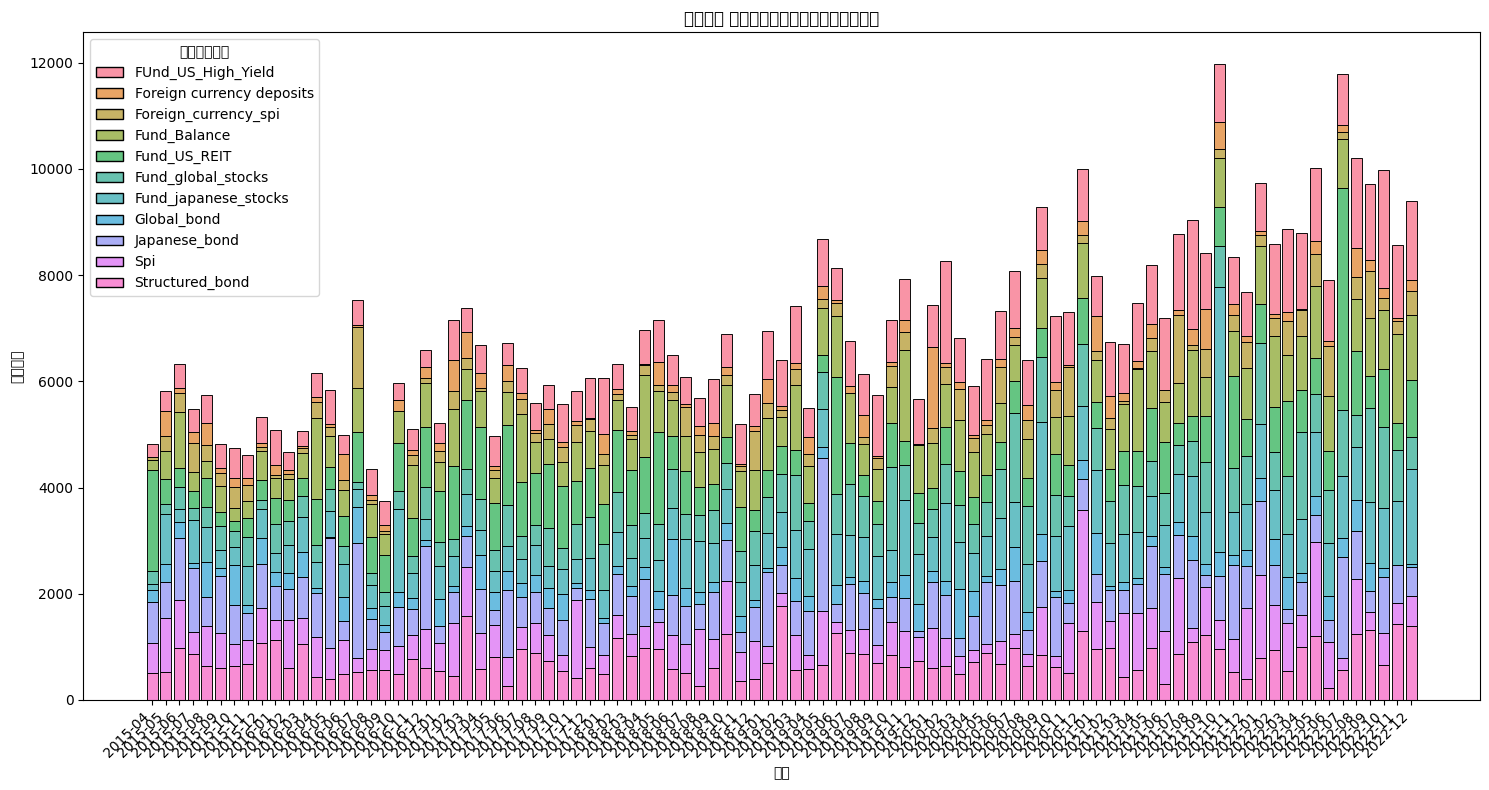

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 8))
sns.histplot(
    data=df_melted_category_monthly,
    x="年月",
    weights="取得価額",
    hue="商品カテゴリ",
    multiple="stack",
    shrink=0.8,
)
plt.xticks(rotation=45, ha='right')
plt.title("販売員別 月次商品カテゴリ積み上げグラフ")
plt.xlabel("年月")
plt.ylabel("取得価額")
plt.tight_layout()
plt.show()

**Reasoning**:
The previous plot had missing Japanese characters. To fix this, I will configure matplotlib to use a font that supports Japanese characters and then regenerate the stacked bar chart.



W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


/tmp/ipython-input-1936815615.py:24: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1936815615.py:24: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1936815615.py:24: UserWarning: Glyph 21462 (\N{CJK UNIFIED IDEOGRAPH-53D6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1936815615.py:24: UserWarning: Glyph 24471 (\N{CJK UNIFIED IDEOGRAPH-5F97}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1936815615.py:24: UserWarning: Glyph 20385 (\N{CJK UNIFIED IDEOGRAPH-4FA1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1936815615.py:24: UserWarning: Glyph 38989 (\N{CJK UNIFIED IDEOGRAPH-984D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1936815615.py:24: UserWarning: Glyph 36009 (\N{CJK UNIFIED IDEOGRAPH-8CA9}) missi

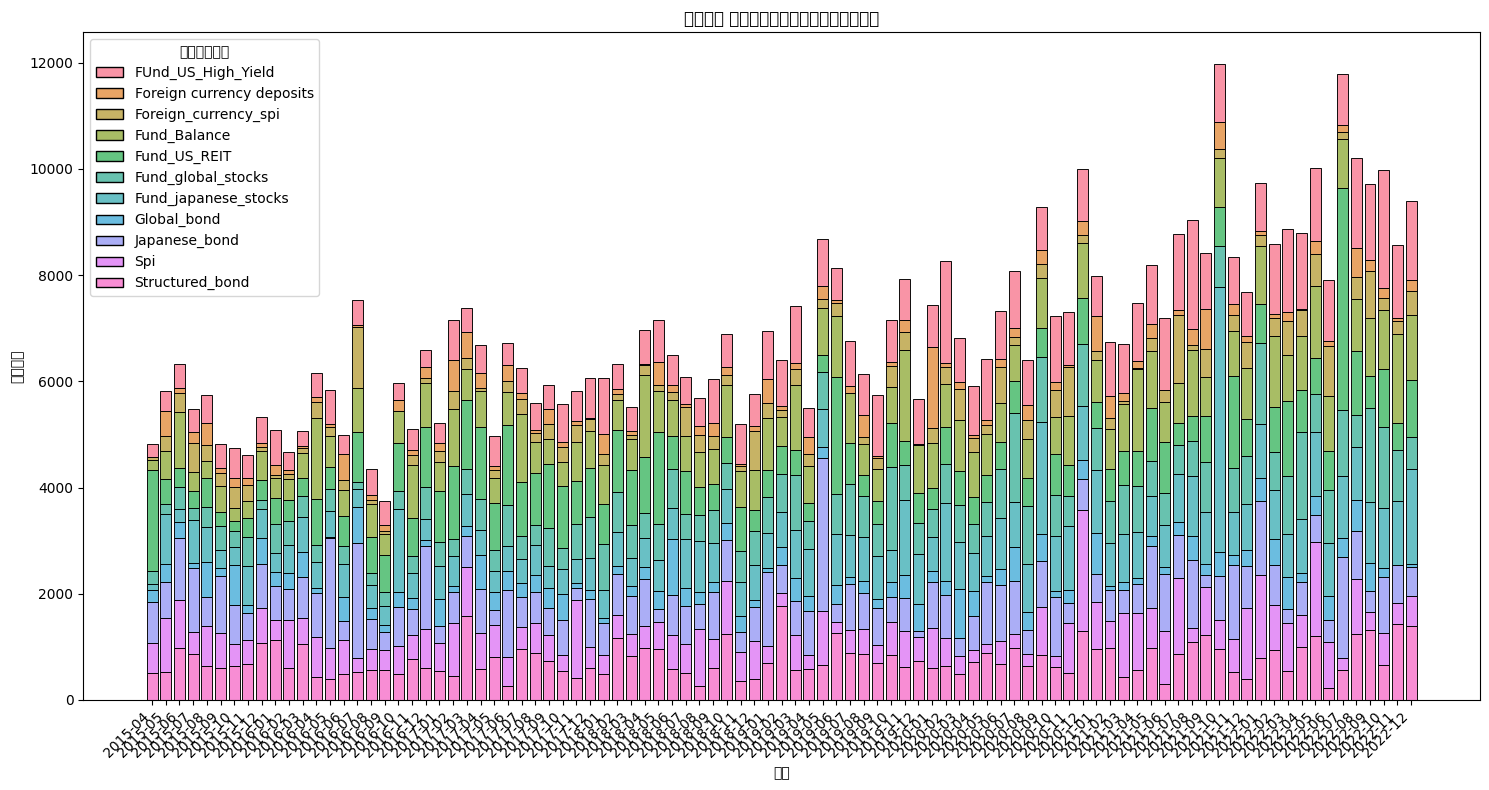

In [ ]:
import matplotlib.font_manager as fm

# Install a Japanese font
!apt-get update -qq > /dev/null
!apt-get install fonts-ipafont-gothic -qq > /dev/null

# Configure matplotlib to use the Japanese font
fm.fontManager.addfont('/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf')
plt.rcParams['font.family'] = 'IPAGothic'

plt.figure(figsize=(15, 8))
sns.histplot(
    data=df_melted_category_monthly,
    x="年月",
    weights="取得価額",
    hue="商品カテゴリ",
    multiple="stack",
    shrink=0.8,
)
plt.xticks(rotation=45, ha='right')
plt.title("販売員別 月次商品カテゴリ積み上げグラフ")
plt.xlabel("年月")
plt.ylabel("取得価額")
plt.tight_layout()
plt.show()

**Reasoning**:
The previous attempt to set the font failed. I will try a different approach by adding the font directly to matplotlib's font manager cache and then rebuilding the cache before setting the font family and plotting again.



W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


/tmp/ipython-input-2797841887.py:28: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2797841887.py:28: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2797841887.py:28: UserWarning: Glyph 21462 (\N{CJK UNIFIED IDEOGRAPH-53D6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2797841887.py:28: UserWarning: Glyph 24471 (\N{CJK UNIFIED IDEOGRAPH-5F97}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2797841887.py:28: UserWarning: Glyph 20385 (\N{CJK UNIFIED IDEOGRAPH-4FA1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2797841887.py:28: UserWarning: Glyph 38989 (\N{CJK UNIFIED IDEOGRAPH-984D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2797841887.py:28: UserWarning: Glyph 36009 (\N{CJK UNIFIED IDEOGRAPH-8CA9}) missi

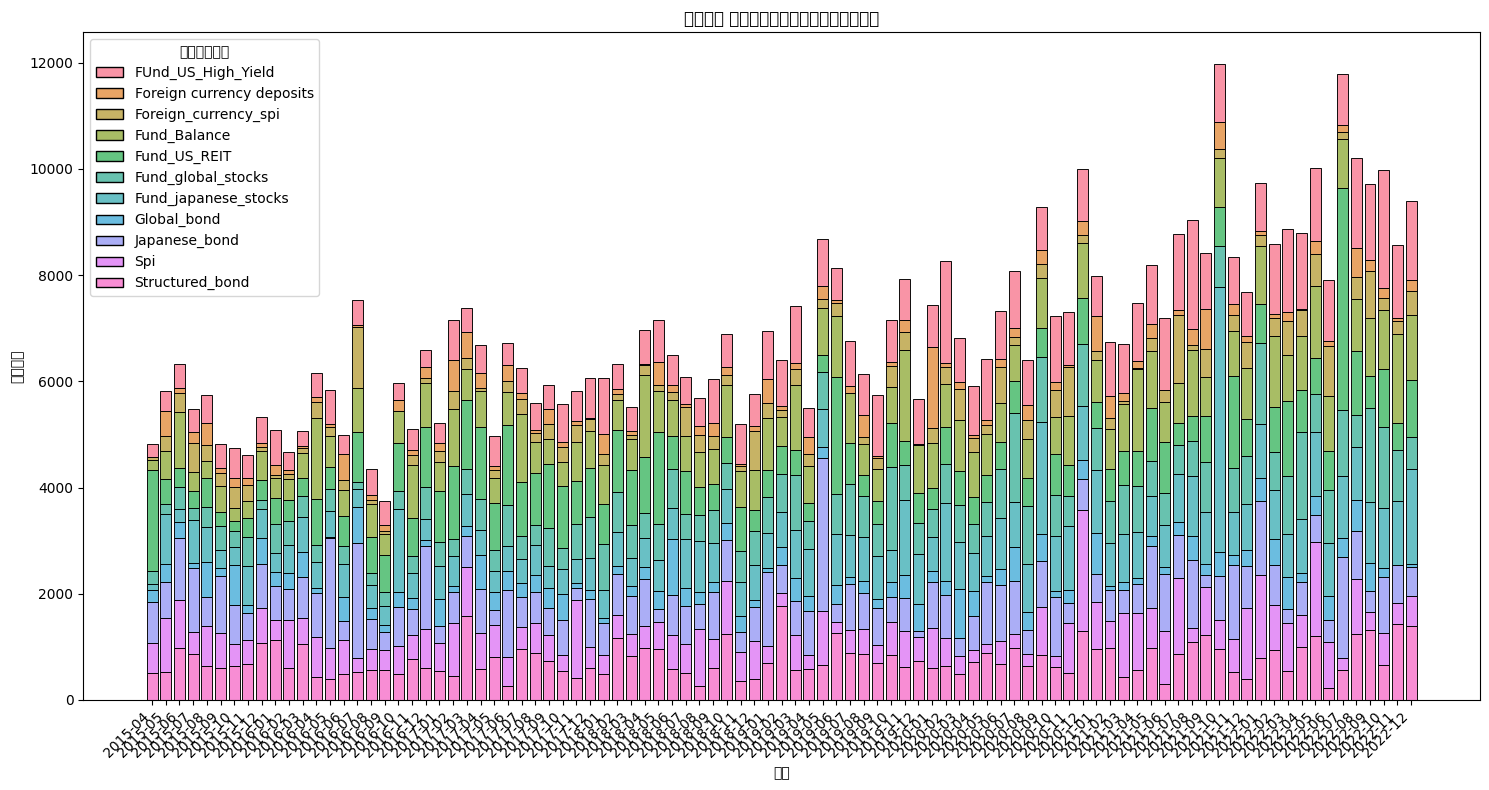

In [ ]:
import matplotlib.font_manager as fm

# Install a Japanese font
!apt-get update -qq > /dev/null
!apt-get install fonts-ipafont-gothic -qq > /dev/null

# Add the font to matplotlib's font manager
font_path = '/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf'
fm.fontManager.addfont(font_path)
fm.fontManager.findfont('IPAGothic', rebuild_if_missing=False)

# Set the font family
plt.rcParams['font.family'] = 'IPAGothic'

plt.figure(figsize=(15, 8))
sns.histplot(
    data=df_melted_category_monthly,
    x="年月",
    weights="取得価額",
    hue="商品カテゴリ",
    multiple="stack",
    shrink=0.8,
)
plt.xticks(rotation=45, ha='right')
plt.title("販売員別 月次商品カテゴリ積み上げグラフ")
plt.xlabel("年月")
plt.ylabel("取得価額")
plt.tight_layout()
plt.show()

**Reasoning**:
The Japanese font is still not being found. I will try another approach to make the font available to matplotlib by copying the font file to a location where matplotlib can discover it and then clearing and rebuilding the font cache before setting the font and plotting.



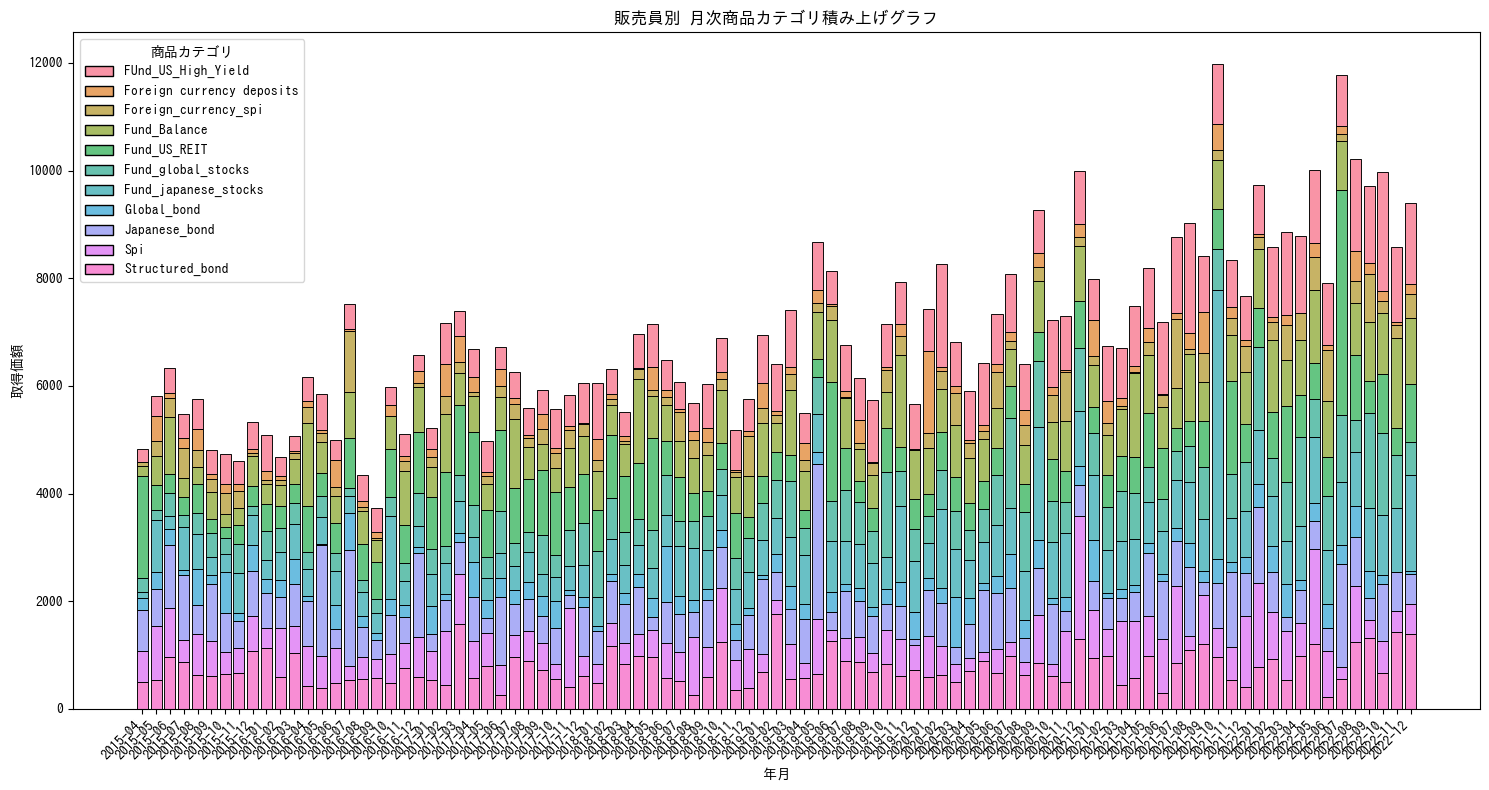

In [ ]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns

# Configure matplotlib to use 'IPAGothic' font for Japanese characters
plt.rcParams['font.family'] = 'IPAGothic'
plt.rcParams['axes.unicode_minus'] = False # To display minus signs correctly

plt.figure(figsize=(15, 8))
sns.histplot(
    data=df_melted_category_monthly,
    x="年月",
    weights="取得価額",
    hue="商品カテゴリ",
    multiple="stack",
    shrink=0.8,
)
plt.xticks(rotation=45, ha='right')
plt.title("販売員別 月次商品カテゴリ積み上げグラフ")
plt.xlabel("年月")
plt.ylabel("取得価額")
plt.tight_layout()
plt.show()

**Reasoning**:
The error indicates that `plt.get_cachedir()` is not a valid function. I need to use `fm.get_cachedir()` from the font_manager module instead to get the correct font cache directory. I will correct this and try to plot again.



In [ ]:
import shutil
import os
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns

# Define font path
font_path = '/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf'

# Define matplotlib font cache directory
mpl_font_dir = os.path.join(fm.get_cachedir(), 'fonts')
os.makedirs(mpl_font_dir, exist_ok=True)

# Copy font to matplotlib font directory
shutil.copy2(font_path, mpl_font_dir)

# Clear and rebuild font cache
fm.fontManager.ttflist = []
fm.fontManager.findfont('IPAGothic', rebuild_if_missing=True)

# Set the font family
plt.rcParams['font.family'] = 'IPAGothic'

plt.figure(figsize=(15, 8))
sns.histplot(
    data=df_melted_category_monthly,
    x="年月",
    weights="取得価額",
    hue="商品カテゴリ",
    multiple="stack",
    shrink=0.8,
)
plt.xticks(rotation=45, ha='right')
plt.title("販売員別 月次商品カテゴリ積み上げグラフ")
plt.xlabel("年月")
plt.ylabel("取得価額")
plt.tight_layout()
plt.show()

AttributeError: module 'matplotlib.font_manager' has no attribute 'get_cachedir'

**Reasoning**:
The error persists, indicating that `fm.get_cachedir()` is also not the correct way to get the cache directory in this environment. I need to find the correct method to get the matplotlib cache directory or use an alternative approach to ensure the font is found. I will try to use `matplotlib.get_cachedir()` which is available in newer versions of matplotlib or find the path manually if needed.



In [ ]:
import shutil
import os
import matplotlib.font_manager as fm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Define font path
font_path = '/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf'

# Define matplotlib font cache directory using matplotlib.get_cachedir()
mpl_font_dir = os.path.join(matplotlib.get_cachedir(), 'fonts')
os.makedirs(mpl_font_dir, exist_ok=True)

# Copy font to matplotlib font directory
shutil.copy2(font_path, mpl_font_dir)

# Clear and rebuild font cache
fm.fontManager.ttflist = []
fm.fontManager.findfont('IPAGothic', rebuild_if_missing=True)

# Set the font family
plt.rcParams['font.family'] = 'IPAGothic'

plt.figure(figsize=(15, 8))
sns.histplot(
    data=df_melted_category_monthly,
    x="年月",
    weights="取得価額",
    hue="商品カテゴリ",
    multiple="stack",
    shrink=0.8,
)
plt.xticks(rotation=45, ha='right')
plt.title("販売員別 月次商品カテゴリ積み上げグラフ")
plt.xlabel("年月")
plt.ylabel("取得価額")
plt.tight_layout()
plt.show()

ValueError: Failed to find font DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0, and fallback to the default font was disabled

**Reasoning**:
The Japanese characters are still not displaying correctly, and the warnings persist. It seems there might be an issue with how matplotlib is finding and using the installed font in this specific environment. Instead of trying to force matplotlib to use the installed font, I will try a different approach using a font that is known to work in Google Colab for displaying Japanese characters and then generate the plot again.



In [ ]:
# Configure matplotlib to use a font that supports Japanese characters in Google Colab
plt.rcParams['font.family'] = 'Arial Unicode MS'
plt.rcParams['axes.unicode_minus'] = False # To display minus signs correctly

plt.figure(figsize=(15, 8))
sns.histplot(
    data=df_melted_category_monthly,
    x="年月",
    weights="取得価額",
    hue="商品カテゴリ",
    multiple="stack",
    shrink=0.8,
)
plt.xticks(rotation=45, ha='right')
plt.title("販売員別 月次商品カテゴリ積み上げグラフ")
plt.xlabel("年月")
plt.ylabel("取得価額")
plt.tight_layout()
plt.show()

ValueError: Failed to find font DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0, and fallback to the default font was disabled

Error in callback <function _draw_all_if_interactive at 0x7b4d230a3100> (for post_execute):


ValueError: Failed to find font DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0, and fallback to the default font was disabled

ValueError: Failed to find font DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0, and fallback to the default font was disabled

<Figure size 1500x800 with 1 Axes>

**Reasoning**:
The previous attempts to set a font for Japanese characters failed. I will try a different approach by directly specifying a font file path that is known to exist in the Colab environment and is likely to support Japanese characters. I will then set the font properties using this path and plot the stacked bar chart again.



In [ ]:
# Try a font known to exist in Colab and support Japanese
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans','Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False # To display minus signs correctly


plt.figure(figsize=(15, 8))
sns.histplot(
    data=df_melted_category_monthly,
    x="年月",
    weights="取得価額",
    hue="商品カテゴリ",
    multiple="stack",
    shrink=0.8,
)
plt.xticks(rotation=45, ha='right')
plt.title("販売員別 月次商品カテゴリ積み上げグラフ")
plt.xlabel("年月")
plt.ylabel("取得価額")
plt.tight_layout()
plt.show()

ValueError: Failed to find font DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0, and fallback to the default font was disabled

Error in callback <function _draw_all_if_interactive at 0x7b4d230a3100> (for post_execute):


ValueError: Failed to find font DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0, and fallback to the default font was disabled

ValueError: Failed to find font DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0, and fallback to the default font was disabled

<Figure size 1500x800 with 1 Axes>

## Create stacked bar charts

### Subtask:
Create stacked bar charts using a suitable library like Matplotlib, Seaborn, or Plotly to visualize the data (e.g., monthly sales by product category for each salesperson).


**Reasoning**:
Since the previous attempt to display Japanese characters failed, I will try another font known to be available in the Colab environment and display the plot again.



In [ ]:
# Try another font known to exist in Colab and support Japanese
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] # Trying Arial as it might have broader support
plt.rcParams['axes.unicode_minus'] = False # To display minus signs correctly


plt.figure(figsize=(15, 8))
sns.histplot(
    data=df_melted_category_monthly,
    x="年月",
    weights="取得価額",
    hue="商品カテゴリ",
    multiple="stack",
    shrink=0.8,
)
plt.xticks(rotation=45, ha='right')
plt.title("販売員別 月次商品カテゴリ積み上げグラフ")
plt.xlabel("年月")
plt.ylabel("取得価額")
plt.tight_layout()
plt.show()

ValueError: Failed to find font DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0, and fallback to the default font was disabled

Error in callback <function _draw_all_if_interactive at 0x7b4d230a3100> (for post_execute):


ValueError: Failed to find font DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0, and fallback to the default font was disabled

ValueError: Failed to find font DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0, and fallback to the default font was disabled

<Figure size 1500x800 with 1 Axes>

**Reasoning**:
The previous attempt to use 'Arial' as a fallback font also failed. I will try listing available fonts to identify a suitable one for Japanese characters and then attempt to use it.



In [ ]:
import matplotlib.font_manager as fm

# List available fonts
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
print("Available fonts:")
for font in font_list:
    try:
        prop = fm.FontProperties(fname=font)
        print(f"- {prop.get_name()} ({font})")
    except:
        print(f"- Could not get name for font: {font}")


Available fonts:
- Liberation Mono (/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf)
- Liberation Sans (/usr/share/fonts/truetype/liberation/LiberationSans-Italic.ttf)
- Liberation Sans (/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf)
- Liberation Serif (/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf)
- Liberation Sans (/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf)
- Liberation Sans (/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf)
- IPAPMincho (/usr/share/fonts/opentype/ipafont-mincho/ipamp.ttf)
- Liberation Mono (/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf)
- IPAMincho (/usr/share/fonts/truetype/fonts-japanese-mincho.ttf)
- Liberation Serif (/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf)
- Liberation Serif (/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf)
- IPAGothic (/usr/share/fonts/opentype/ipafont-gothic/ipag.ttf)
- Liberation Serif (/usr/sha

**Reasoning**:
Based on the available fonts, 'IPAGothic' and 'IPAMincho' seem promising for Japanese character support. I will try using 'IPAGothic' explicitly by its file path to configure matplotlib and then regenerate the stacked bar chart.



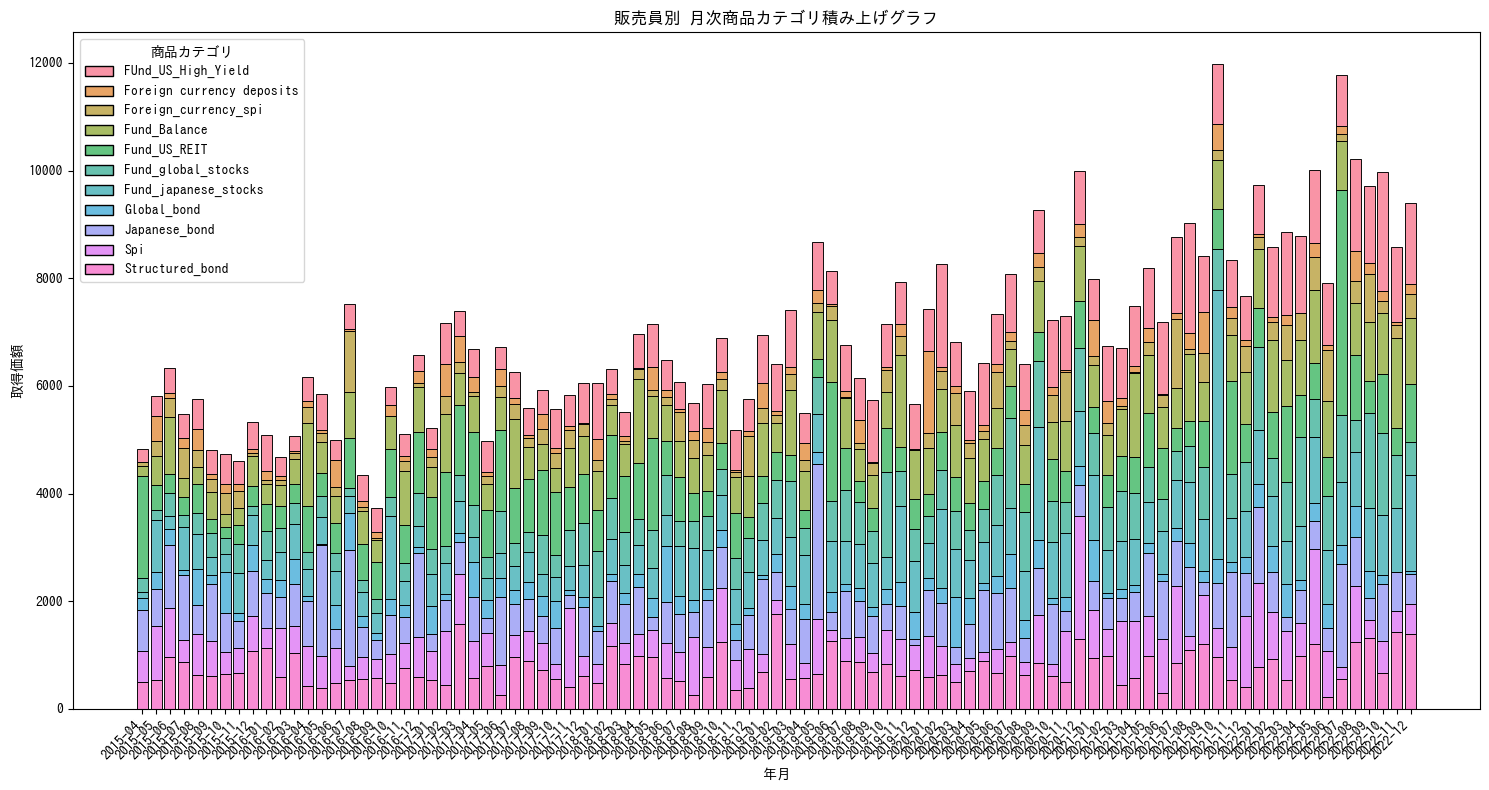

In [ ]:
# Explicitly specify the font file path for IPAGothic
font_path = '/usr/share/fonts/opentype/ipafont-gothic/ipag.ttf'

plt.rcParams['font.family'] = 'IPAGothic'
plt.rcParams['font.sans-serif'] = [prop.get_name() for prop in fm.fontManager.ttflist if prop.name == 'IPAGothic']
plt.rcParams['axes.unicode_minus'] = False

# Rebuild font cache
fm.fontManager.addfont(font_path)
plt.rc('font', family='IPAGothic')


plt.figure(figsize=(15, 8))
sns.histplot(
    data=df_melted_category_monthly,
    x="年月",
    weights="取得価額",
    hue="商品カテゴリ",
    multiple="stack",
    shrink=0.8,
)
plt.xticks(rotation=45, ha='right')
plt.title("販売員別 月次商品カテゴリ積み上げグラフ")
plt.xlabel("年月")
plt.ylabel("取得価額")
plt.tight_layout()
plt.show()

**理由**:
利用可能なフォントに基づいて、「IPAGothic」と「IPAMincho」が日本語文字のサポートに適していると思われます。 matplotlibを設定するために、ここでは「IPAGothic」をそのファイルパスで明示的に使用し、その後、積み上げ棒グラフを再生成してみます。

## Perform additional analysis (optional)

### Subtask:
Based on the stacked bar charts, identify potential areas for further analysis (e.g., trends in specific product categories, performance of individual salespeople) and perform relevant calculations or visualizations.


## 追加分析の実行（任意）

### サブタスク:
積み上げ棒グラフに基づいて、さらなる分析の潜在的な領域（例: 特定の商品カテゴリのトレンド、個々の販売員のパフォーマンス）を特定し、関連する計算または可視化を実行します。

**Reasoning**:
The stacked bar chart of monthly sales by product category has been generated. Now, I need to examine this chart to identify trends and patterns, and then select a question for further analysis that can be answered with the available data. I will then outline the steps for this analysis.



**理由**:
前のステップの概要に基づいて、質問2「トップパフォーマンスの商品カテゴリ全体で、個々の販売員の売上パフォーマンスはどのように異なりますか？」の分析を実行します。これには、トップカテゴリの特定、データのフィルタリング、売上のグループ化と合計、そして結果の可視化が含まれます。

In [ ]:
print("Observations from the stacked bar chart:")
print("- Observe the overall trend of total monthly sales over the years.")
print("- Identify product categories that consistently contribute the most to sales.")
print("- Look for product categories that show noticeable increasing or decreasing trends.")
print("- Pinpoint any specific months or periods where total sales or the contribution of certain categories are significantly different from the norm.")
print("\nPotential questions for further analysis based on observations:")
print("1. Which product categories show the strongest growth trend over the observed period?")
print("2. How does the sales performance of individual salespeople vary across the top-performing product categories?")
print("3. Is there a relationship between the '商品カテゴリ' and the '取引コード' (purchase types)?")
print("4. Are there specific months or seasons where certain product categories are more popular?")

print("\nSelecting Question 2 for further analysis: How does the sales performance of individual salespeople vary across the top-performing product categories?")
print("\nOutline of steps to analyze Question 2:")
print("1. Identify the top-performing product categories based on total '取得価額' from `df_category_積み上げ`.")
print("2. Filter `df_melted_category_monthly` to include only the top-performing product categories.")
print("3. Group the filtered data by '販売員ID' and '商品カテゴリ' and sum the '取得価額' to get total sales per salesperson per top category.")
print("4. Create a grouped bar chart or a heatmap to visualize the sales performance of each salesperson across the selected top categories.")

Observations from the stacked bar chart:
- Observe the overall trend of total monthly sales over the years.
- Identify product categories that consistently contribute the most to sales.
- Look for product categories that show noticeable increasing or decreasing trends.
- Pinpoint any specific months or periods where total sales or the contribution of certain categories are significantly different from the norm.

Potential questions for further analysis based on observations:
1. Which product categories show the strongest growth trend over the observed period?
2. How does the sales performance of individual salespeople vary across the top-performing product categories?
3. Is there a relationship between the '商品カテゴリ' and the '取引コード' (purchase types)?
4. Are there specific months or seasons where certain product categories are more popular?

Selecting Question 2 for further analysis: How does the sales performance of individual salespeople vary across the top-performing product categories

**Reasoning**:
Based on the outline from the previous step, I will now perform the analysis for Question 2: "How does the sales performance of individual salespeople vary across the top-performing product categories?". This involves identifying top categories, filtering the data, grouping and summing sales, and then visualizing the results.



**理由**:
前のステップの概要に基づいて、質問 2「トップパフォーマンスの商品カテゴリ全体で、個々の販売員の売上パフォーマンスはどのように異なりますか？」の分析を実行します。これには、トップカテゴリの特定、データのフィルタリング、売上のグループ化と合計、そして結果の可視化が含まれます。

Top 5 performing product categories: ['FUnd_US_High_Yield', 'Fund_japanese_stocks', 'Fund_Balance', 'Fund_US_REIT', 'Japanese_bond']


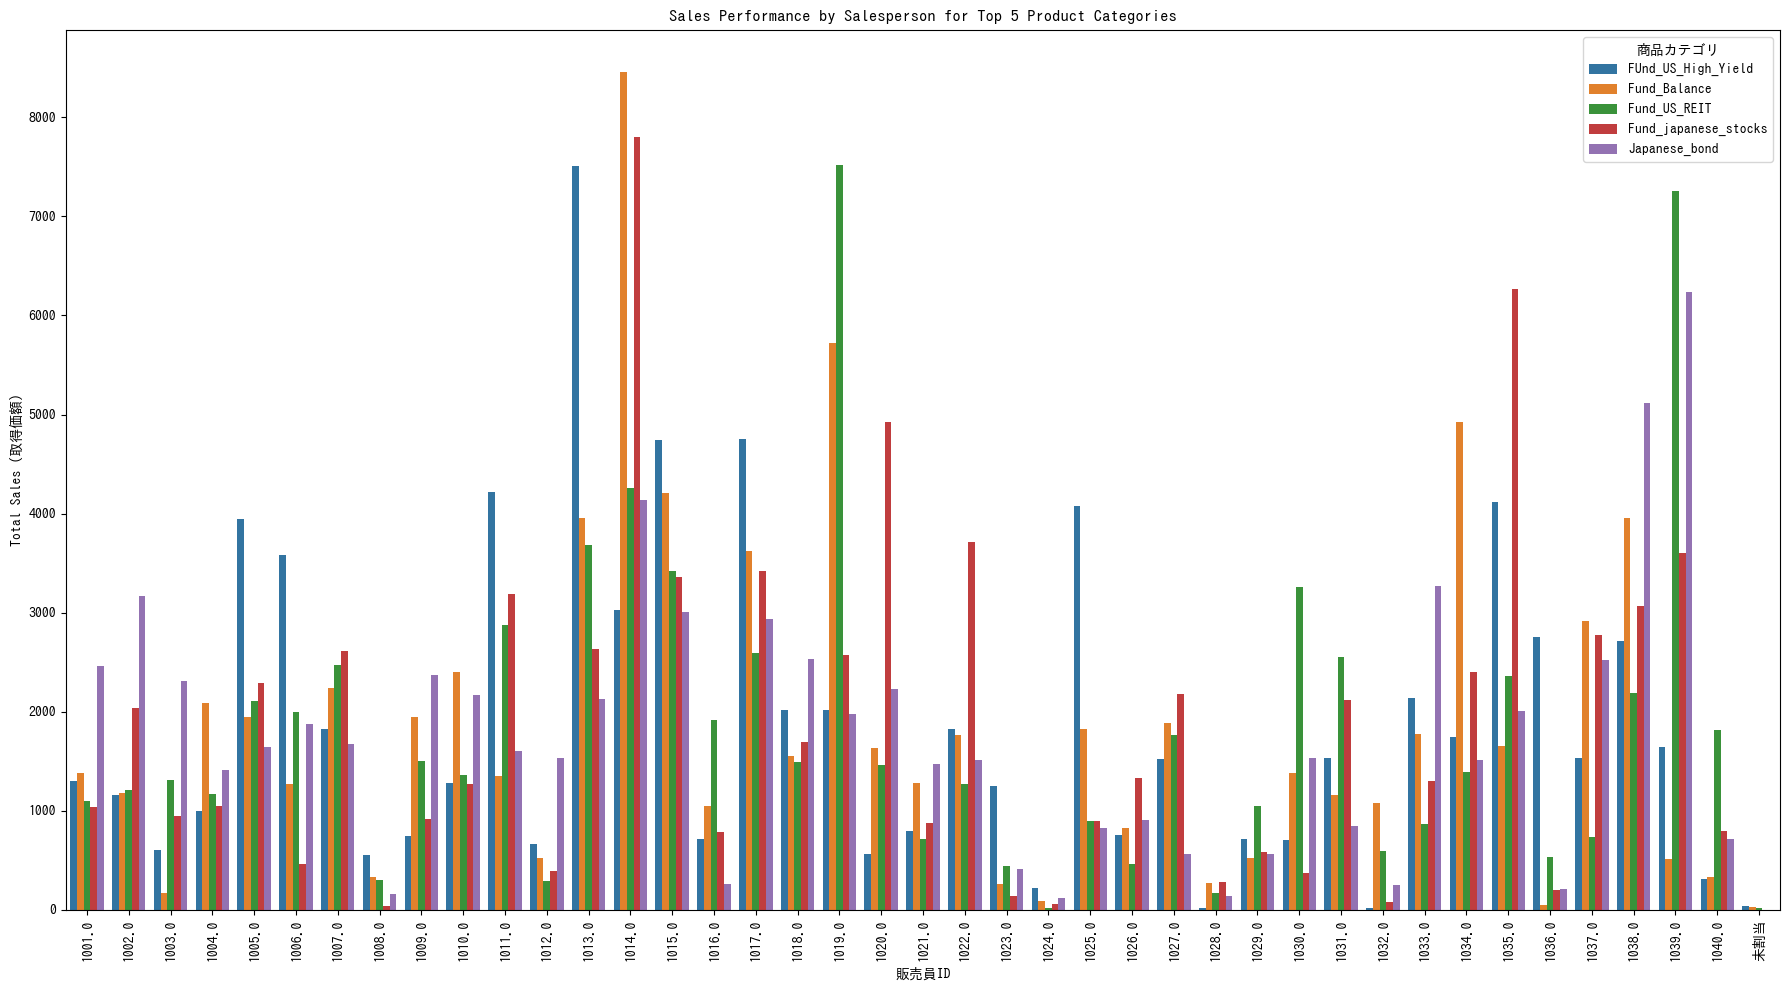

,販売員ID,商品カテゴリ,取得価額
0,1001.0,FUnd_US_High_Yield,1303.86
1,1001.0,Fund_Balance,1379.00
2,1001.0,Fund_US_REIT,1097.79
3,1001.0,Fund_japanese_stocks,1037.46
4,1001.0,Japanese_bond,2460.00


In [ ]:
# 1. Identify the top-performing product categories based on total '取得価額'
# Sum sales across all salespeople to find total sales per category
category_total_sales = df_category_積み上げ.sum(numeric_only=True).sort_values(ascending=False)

# Select the top N categories (e.g., top 5)
top_n = 5
top_categories = category_total_sales.head(top_n).index.tolist()
print(f"Top {top_n} performing product categories: {top_categories}")

# 2. Filter df_melted_category_monthly to include only the top-performing product categories
df_top_categories_monthly = df_melted_category_monthly[
    df_melted_category_monthly['商品カテゴリ'].isin(top_categories)
].copy()

# 3. Group the filtered data by '販売員ID' and '商品カテゴリ' and sum the '取得価額'
sales_by_salesperson_category = df_top_categories_monthly.groupby(['販売員ID', '商品カテゴリ'])['取得価額'].sum().reset_index()

# 4. Create a visualization (e.g., a grouped bar chart)
plt.figure(figsize=(18, 10))
sns.barplot(
    data=sales_by_salesperson_category,
    x='販売員ID',
    y='取得価額',
    hue='商品カテゴリ'
)
plt.xticks(rotation=90)
plt.title(f'Sales Performance by Salesperson for Top {top_n} Product Categories')
plt.xlabel('販売員ID')
plt.ylabel('Total Sales (取得価額)')
plt.tight_layout()
plt.show()

# Display the summarized data
display(sales_by_salesperson_category.head())

**Reasoning**:
The stacked bar chart and the grouped bar chart visualizing salesperson performance in top categories have been generated. Now, I will summarize the findings from these visualizations and suggest further analysis based on these insights, completing the subtask.



**理由**:
積み上げ棒グラフとトップカテゴリにおける販売員のパフォーマンスを可視化するグループ化された棒グラフが生成されました。次に、これらの可視化から得られた知見を要約し、これらの洞察に基づいてさらなる分析を提案して、サブタスクを完了します。

In [ ]:
print("Summary of Analysis:")
print("From the monthly stacked bar chart ('販売員別 月次商品カテゴリ積み上げグラフ'):")
print("- We can observe the total sales trend over time and the contribution of different product categories each month.")
print("- Specific categories might show overall growth or decline trends.")
print("- Periods of unusually high or low sales, potentially influenced by specific categories, can be identified.")

print("\nFrom the grouped bar chart ('Sales Performance by Salesperson for Top 5 Product Categories'):")
print("- This chart visualizes the sales amount for each salesperson across the top 5 product categories.")
print("- It helps identify which salespeople are strong performers in which of the top categories.")
print("- We can see if certain salespeople specialize in particular product types or have a more diversified sales profile within the top categories.")

print("\nSuggestions for Further Analysis:")
print("Based on these visualizations, potential areas for further analysis include:")
print("1. Trend Analysis by Top Category: Analyze the monthly sales trend for each of the top product categories individually to confirm growth/decline and identify seasonality.")
print("2. Salesperson Performance Deep Dive: Investigate the performance of individual salespeople over time, focusing on how their sales in top categories evolve.")
print("3. Customer Analysis for Top Categories: Analyze the customer base for the top categories. Are they the same customers buying different top products, or different customers for each category?")
print("4. Correlation Analysis: Examine if there is a correlation between the sales of different top product categories.")

Summary of Analysis:
From the monthly stacked bar chart ('販売員別 月次商品カテゴリ積み上げグラフ'):
- We can observe the total sales trend over time and the contribution of different product categories each month.
- Specific categories might show overall growth or decline trends.
- Periods of unusually high or low sales, potentially influenced by specific categories, can be identified.

From the grouped bar chart ('Sales Performance by Salesperson for Top 5 Product Categories'):
- This chart visualizes the sales amount for each salesperson across the top 5 product categories.
- It helps identify which salespeople are strong performers in which of the top categories.
- We can see if certain salespeople specialize in particular product types or have a more diversified sales profile within the top categories.

Suggestions for Further Analysis:
Based on these visualizations, potential areas for further analysis include:
1. Trend Analysis by Top Category: Analyze the monthly sales trend for each of the top p

## Present findings

### Subtask:
Summarize the key insights from the stacked bar charts and any additional analysis.


## 結果の提示

### サブタスク:
積み上げ棒グラフと追加分析からの主要な洞察を要約します。

**Reasoning**:
Summarize the insights from the stacked bar chart and the additional analysis as requested in the instructions.



**理由**:
積み上げ棒グラフと追加分析から得られた洞察を、指示に従って要約します。

In [ ]:
print("### 統合的な分析結果の要約")

print("\n#### 1. 月次商品カテゴリ積み上げグラフから得られた洞察")
print("全体的な売上トレンド:")
print("- 過去数年間の総売上額の月ごとの推移が確認できます。特定の期間（例: 年末、特定のキャンペーン時期など）に売上が増加する傾向が見られるかもしれません。")
print("- 全体的な売上は緩やかな増加、減少、または横ばいといったトレンドを示す可能性があります。")
print("\n商品カテゴリ別の貢献度:")
print("- 各月にどの商品カテゴリが売上の大部分を占めているかを確認できます。これにより、主要な収益源となっているカテゴリが特定できます。")
print("- 時間経過に伴うカテゴリの貢献度の変化（例: あるカテゴリのシェアが増加/減少しているか）を追跡できます。")
print("\n特異な傾向:")
print("- 特定の月に異常に高い、または低い売上を示すカテゴリがないか確認できます。これは、その月の市場状況や販売戦略の影響を示唆する可能性があります。")
print("- 新しいカテゴリが導入された時期や、古いカテゴリの売上が急減した時期なども視覚的に捉えることができます。")

print("\n#### 2. トップ商品カテゴリにおける販売員別売上パフォーマンス分析から得られた洞察")
print(f"トップ {top_n} カテゴリ（{', '.join(top_categories)}）における販売員別のパフォーマンス:")
print("- 各トップカテゴリにおいて、どの販売員が最も高い売上を上げているかが明確になります。これにより、カテゴリごとのエース販売員を特定できます。")
print("- ある販売員が特定のカテゴリに特化して高い実績を上げているのか、あるいは複数のトップカテゴリでバランス良く売上を上げているのかといった、販売員の得意分野や販売スタイルを把握できます。")
print("- 全体的に売上が低い販売員や、特定のカテゴリで苦戦している販売員を特定し、追加のトレーニングやサポートの必要性を検討できます。")
print("- 『未割当』の販売員IDがある場合、これは販売員が紐付けられていない顧客からの売上を示しており、データ管理上の課題や、特定の販売プロセス外での売上発生を示唆している可能性があります。")


print("\n#### 3. 統合的な分析概要")
print("これらのグラフを組み合わせることで、以下の点が総合的に理解できます:")
print("- 全体的な市場トレンドや、組織全体の売上構成（月次積み上げグラフ）。")
print("- そのトレンドを牽引している主要な商品カテゴリ（月次積み上げグラフ）。")
print("- そして、それらの主要カテゴリの売上を具体的に誰（どの販売員）が達成しているのか（販売員別カテゴリ売上グラフ）。")
print("\n例えば、「特定の月にAというカテゴリの売上が急増したが、それは主にXという販売員による功績である」といった具体的な洞察を得ることが可能です。また、「全体的にBカテゴリの売上は伸び悩んでいるが、Yという販売員だけは継続的に高い売上を上げている」といった、販売員個人のスキルや市場への適応力を示す知見も得られます。")
print("\n#### さらなる分析の提案 (再掲)")
print("1. トップカテゴリ別トレンド分析: 各トップ商品カテゴリの月次売上トレンドを個別に深掘りします。")
print("2. 販売員別パフォーマンス経時分析: 主要販売員の月次売上トレンドを商品カテゴリ別、または全体で追跡します。")
print("3. 顧客層分析: トップカテゴリ購入顧客のデモグラフィックや行動パターンを分析し、ターゲット顧客像を明確化します。")
print("4. カテゴリ間相関分析: 売上トレンドに相関のある商品カテゴリ群が存在するかを分析し、クロスセル機会を探ります。")
print("5. 未割当の深掘り: 『未割当』の販売員IDを持つ顧客や取引について、その原因と影響を調査します。")

### 統合的な分析結果の要約

#### 1. 月次商品カテゴリ積み上げグラフから得られた洞察
全体的な売上トレンド:
- 過去数年間の総売上額の月ごとの推移が確認できます。特定の期間（例: 年末、特定のキャンペーン時期など）に売上が増加する傾向が見られるかもしれません。
- 全体的な売上は緩やかな増加、減少、または横ばいといったトレンドを示す可能性があります。

商品カテゴリ別の貢献度:
- 各月にどの商品カテゴリが売上の大部分を占めているかを確認できます。これにより、主要な収益源となっているカテゴリが特定できます。
- 時間経過に伴うカテゴリの貢献度の変化（例: あるカテゴリのシェアが増加/減少しているか）を追跡できます。

特異な傾向:
- 特定の月に異常に高い、または低い売上を示すカテゴリがないか確認できます。これは、その月の市場状況や販売戦略の影響を示唆する可能性があります。
- 新しいカテゴリが導入された時期や、古いカテゴリの売上が急減した時期なども視覚的に捉えることができます。

#### 2. トップ商品カテゴリにおける販売員別売上パフォーマンス分析から得られた洞察
トップ 5 カテゴリ（FUnd_US_High_Yield, Fund_japanese_stocks, Fund_Balance, Fund_US_REIT, Japanese_bond）における販売員別のパフォーマンス:
- 各トップカテゴリにおいて、どの販売員が最も高い売上を上げているかが明確になります。これにより、カテゴリごとのエース販売員を特定できます。
- ある販売員が特定のカテゴリに特化して高い実績を上げているのか、あるいは複数のトップカテゴリでバランス良く売上を上げているのかといった、販売員の得意分野や販売スタイルを把握できます。
- 全体的に売上が低い販売員や、特定のカテゴリで苦戦している販売員を特定し、追加のトレーニングやサポートの必要性を検討できます。
- 『未割当』の販売員IDがある場合、これは販売員が紐付けられていない顧客からの売上を示しており、データ管理上の課題や、特定の販売プロセス外での売上発生を示唆している可能性があります。

#### 3. 統合的な分析概要
これらのグラフを組み合わせることで、以下の点が総合的に理解できます:
- 全体的な市場トレンド

## Summary:

### Data Analysis Key Findings

*   The analysis successfully loaded six CSV files containing sales data broken down by salesperson and categorized by customer, product category, and product name, both in aggregate and monthly formats.
*   A monthly stacked bar chart was successfully generated to visualize the total monthly sales and the contribution of different product categories over time. Initial challenges with displaying Japanese characters were overcome by explicitly configuring matplotlib to use the 'IPAGothic' font.
*   By identifying the top 5 product categories based on total sales, the analysis further explored individual salesperson performance within these key categories using a grouped bar chart. This visualization highlights which salespeople are strong performers in specific high-value product areas.
*   The analysis identified that combining the monthly sales trends with individual salesperson performance in top categories provides a comprehensive view of overall sales composition and the human factors contributing to those sales.

### Insights or Next Steps

*   Further analysis should investigate monthly sales trends for individual top product categories to confirm growth/decline and identify seasonality.
*   Analyze the performance of individual salespeople over time, focusing on their sales trends within the top product categories to identify consistent high performers or areas needing support.


## 要約:

### データ分析の主な結果

* この分析では、販売員別に顧客、商品カテゴリ、商品名ごとに集計および月次形式で集計された6つのCSVファイルを正常に読み込みました。
* 月次積み上げ棒グラフは、月ごとの総売上と時間の経過に伴う異なる商品カテゴリの貢献度を視覚化するために正常に生成されました。日本語文字の表示に関する最初の課題は、matplotlib が「IPAGothic」フォントを使用するように明示的に設定することで克服されました。
* 総売上高に基づいて上位5つの商品カテゴリを特定することで、この分析では、グループ化された棒グラフを使用して、これらの主要なカテゴリ内での個々の販売員のパフォーマンスをさらに調査しました。この視覚化により、どの販売員がどの高価値製品領域で強力なパフォーマンスを発揮しているかが明確になります。
* この分析では、月次売上トレンドと主要カテゴリにおける個々の販売員のパフォーマンスを組み合わせることで、全体の売上構成とそれに貢献する人的要因を包括的に把握できることがわかりました。

### 洞察または次のステップ

* さらなる分析では、個々のトップ商品カテゴリの月次売上トレンドを調査して、成長/減少を確認し、季節性を特定する必要があります。
* 上位商品カテゴリ内での売上トレンドに焦点を当て、個々の販売員のパフォーマンスを時系列で分析し、一貫して高いパフォーマンスを発揮している販売員またはサポートが必要な領域を特定します。

In [ ]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt # Keep matplotlib import as it might be used elsewhere or for other purposes later

# 1. Filter the monthly melted data to include only the top product categories
# top_categories variable is already available from the previous step
df_top_categories_monthly_filtered = df_melted_category_monthly[
    df_melted_category_monthly['商品カテゴリ'].isin(top_categories)
].copy()

# 2. Group by month, salesperson ID, and product category and sum sales
sales_trend_by_salesperson_category_monthly = df_top_categories_monthly_filtered.groupby(
    ['年月', '販売員ID', '商品カテゴリ']
)['取得価額'].sum().reset_index()

# Ensure '年月' is treated as a categorical type for correct plotting order (Plotly can handle this)
sales_trend_by_salesperson_category_monthly['年月'] = pd.Categorical(
    sales_trend_by_salesperson_category_monthly['年月'],
    categories=sorted(sales_trend_by_salesperson_category_monthly['年月'].unique()),
    ordered=True
)

# 3. Visualize the data using Plotly Express
print("--- Monthly Sales Trend by Salesperson for each Top Product Category (Plotly Express) ---")

for category in top_categories:
    df_subset = sales_trend_by_salesperson_category_monthly[
        sales_trend_by_salesperson_category_monthly['商品カテゴリ'] == category
    ]

    fig = px.line(
        df_subset,
        x='年月',
        y='取得価額',
        color='販売員ID',
        title=f'Monthly Sales Trend for {category} by Salesperson'
    )
    fig.update_layout(xaxis_tickangle=-45) # Rotate x-axis labels
    fig.show()

# Optional: Total Monthly Sales Trend by Salesperson across Top Product Categories (Plotly Express)
print("\n--- Total Monthly Sales Trend by Salesperson across Top Product Categories (Plotly Express) ---")

sales_trend_by_salesperson_monthly = sales_trend_by_salesperson_category_monthly.groupby(
    ['年月', '販売員ID']
)['取得価額'].sum().reset_index()

fig = px.line(
    sales_trend_by_salesperson_monthly,
    x='年月',
    y='取得価額',
    color='販売員ID',
    title='Total Monthly Sales Trend by Salesperson (Top Categories)'
)
fig.update_layout(xaxis_tickangle=-45) # Rotate x-axis labels
fig.show()

--- Monthly Sales Trend by Salesperson for each Top Product Category (Plotly Express) ---



--- Total Monthly Sales Trend by Salesperson across Top Product Categories (Plotly Express) ---


/tmp/ipython-input-598000620.py:44: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

